# 3.5. 기부된 의류를 자동으로 분류할 수 있다면

## 3.5.1. 데이터 수집하기

* 컴퓨터가 옷을 보고 어떤 종류의 의류인지 분류하려면 다음과 같은 데이터가 필요하다:
  * 컴퓨터가 인식할 수 있는 형태로 된 의류 데이터
  * 컴퓨터가 자동으로 의류를 분류할 수 있도록 훈련시킬 수 있는 여러 종류의 의류 데이터
  * 컴퓨터가 잘 판단할 수 있는 모델을 갖추었는지 평가할 테스트 데이터
* Fashion MNIST(Modified National Institute of Standards and Technology) 데이터 셋:
  * 훈련 데이터는 60000행, 785열.
  * 각 행의 첫번째 열은 옷 종류를 구분한 레이블 값.
  * 두 번째 열부터 마지막까지는 이미지의 784개 픽셀(28*28) 값.

## 3.5.2. 데이터 불러오기

In [54]:
import pandas as pd

df_train = pd.read_csv('fashion-mnist_train.csv')
df_test = pd.read_csv('fashion-mnist_test.csv')

print(df_train.info(), '\n')
print(df_test.info(), '\n')
print(df_train.shape, '\n')
print(df_test.shape, '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None 

(60000, 785) 

(10000, 785) 



## 3.5.3. 데이터 다루기

In [55]:
import numpy as np

data_train = np.array(df_train, dtype=np.float32)
x_train = data_train[:, 1:]
y_train = data_train[:, 0]

data_test = np.array(df_test)
x_test = data_test[:, 1:]
y_test = data_test[:, 0]

print(df_train)
print(data_train)

print(df_test)
print(data_test)

       label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0          2       0       0       0       0       0       0       0       0   
1          9       0       0       0       0       0       0       0       0   
2          6       0       0       0       0       0       0       0       5   
3          0       0       0       0       1       2       0       0       0   
4          3       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
59995      9       0       0       0       0       0       0       0       0   
59996      1       0       0       0       0       0       0       0       0   
59997      8       0       0       0       0       0       0       0       0   
59998      8       0       0       0       0       0       0       0       0   
59999      7       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel775  pixel776 

## 3.5.4. 데이터 시각화하기

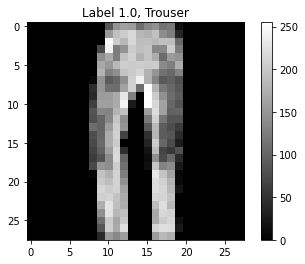

In [56]:
import matplotlib.pyplot as plt

label_dictionary = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

index = 109

plt.imshow(x_train[index].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.title('Label {}, {}'.format(y_train[index], label_dictionary[y_train[index]]))
plt.show()

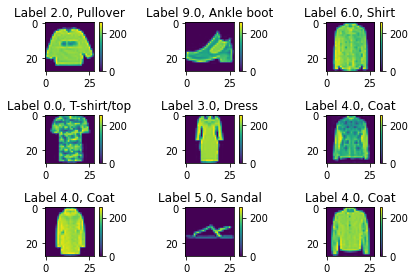

In [57]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.colorbar()
    plt.title('Label {}, {}'.format(y_train[i], label_dictionary[y_train[i]]))

plt.tight_layout()
plt.show()

## 3.5.5. 학습하기

* 옷의 종류는 0부터 9까지의 레이블로 구성된 범주형 데이터.
* 로지스틱 회귀 모델도 범주형 데이터를 분류하는 모델이다.
* 하지만 로지스틱 회귀 모델은 베르누이 확률 분포에만 사용할 수 있다.
* Fashion MNIST 데이터는 10가지로 분류되므로 인공 신경망 모델을 사용해야 한다.

### 신경망 모델의 기본 단위, 퍼셉트론(Perceptron)

* 사람의 신경 세포(뉴런)를 모방한 수학적 모델.
* 퍼셉트론이 신호 $x$를 받아 적당히 변형해 더한 값이 임계값(threshold)을:
  * 초과할 때는 다음으로 신호 $y$를 보내고,
  * 이하일 때는 신호를 보내지 않는다.
* 입력받은 값 $x_1, x_2$들을 더할 때 강화할지, 약화시킬지에 따라 적당한 계수 $w_1, w_2$를 곱한다:
  * 이 과정에서 입력 값이 $w_1x_1, w_2x_2$로 변환된다.
  * 이때 곱하는 계수 $w$들을 가중치(weight)라고 한다.
  * 이렇게 변형해 더한 $w_1x_1 + w_2x_2$ 값이 임계값보다 크면 1, 작으면 0을 출력한다.

#### AND 연산 퍼셉트론

* AND 연산을 하는 퍼셉트론을 만들어본다.
* 퍼셉트론 식이 다소 복잡해 보이지만, 그냥 선형 방정식이다:
  * $y = \begin{cases} 0 &(w_1x_1 + w_2x_2 \leq \text{threshold}) \\ 1 &(w_1x_1 + w_2x_2 \gt \text{threshold}) \end{cases}$
  * 가중치와 임계값은 적당한 값을 넣어 계산해봐야 한다.

In [58]:
def AND(x1, x2):
    w1, w2, threshold = 0.2, 0.2, 0.3
    converted = w1 * x1 + w2 * x2
    if converted <= threshold:
        return 0
    elif converted > threshold:
        return 1

print(AND(0, 0))
print(AND(0, 1))
print(AND(1, 0))
print(AND(1, 1))

0
0
0
1


#### OR 연산 퍼셉트론

* AND 연산 퍼셉트론에서 가중치와 임계값을 변경해 OR 연산 퍼셉트론을 만들 수 있다.

In [59]:
def OR(x1, x2):
    w1, w2, threshold = 0.3, 0.3, 0.2
    converted = w1 * x1 + w2 * x2
    if converted <= threshold:
        return 0
    elif converted > threshold:
        return 1

print(OR(0, 0))
print(OR(0, 1))
print(OR(1, 0))
print(OR(1, 1))

0
1
1
1


#### NAND 연산 퍼셉트론

* NAND 연산은 NOT AND이므로, AND 연산 퍼셉트론의 파라미터에 -1을 곱해준다.

In [60]:
def NAND(x1, x2):
    w1, w2, threshold = -0.2, -0.2, -0.3
    converted = w1 * x1 + w2 * x2
    if converted <= threshold:
        return 0
    elif converted > threshold:
        return 1

print(NAND(0, 0))
print(NAND(0, 1))
print(NAND(1, 0))
print(NAND(1, 1))

1
1
1
0


#### XOR 연산 퍼셉트론

* XOR 연산은 직선으로 분류할 수가 없다.
* 2개 이상의 퍼셉트론을 이용해 층을 추가하면 해결할 수 있다.
  * 이를 다층 퍼셉트론(Multi Layer Perceptron)이라고 한다.
  * 다층 퍼셉트론 구조를 이용하면 비선형 문제를 해결할 수 있다.
  * AND, OR, NAND 퍼셉트론을 사용하면 XOR 다층 퍼셉트론을 만들 수 있다.

In [61]:
def XOR(x1, x2):
    h1 = NAND(x1, x2)
    h2 = OR(x1, x2)
    return AND(h1, h2)

print(XOR(0, 0))
print(XOR(0, 1))
print(XOR(1, 0))
print(XOR(1, 1))

0
1
1
0


### 다층 신경망(MLP)

* 신경망의 구조는 입력층-은닉층-출력층으로 이뤄진다.
  * 입력층 - 신호가 입력되는 계층. 입력 변수가 2개라면 입력층은 2개의 퍼셉트론으로 이뤄진다.
  * 은닉층 - 입력층의 각 퍼셉트론에서 보낸 신호가 모이는 계층. 은닉층을 이루는 퍼셉트론이 많아질수록 신경망이 정교한 판단을 할 수 있다.
  * 출력층 - 신호를 출력하는 계층. 신경망의 목적이 '분류'인지, '회귀'인지에 따라 달라진다. 회귀를 위한 신경망이라면 은닉층에서 받은 신호를 합해 임계치 이상이면 그대로 출력하게 된다.
* Fashion MNIST 데이터 셋의 경우:
  * 입력 변수가 784개이므로 입력층의 퍼셉트론이 784개에 달한다.
  * 너무 복잡해지므로, 이해를 위해 단순화한 신경망 구졸르 먼저 살펴보자.

#### 퍼셉트론 식 $f$의 변형

* 퍼셉트론 식을 변형해 조금 더 실용적이고 복잡한 퍼셉트론을 살펴본다.
* 퍼셉트론의 출력값은 $w_1x_1 + w_2x_2 \gt \text{(threshold)}$가 성립하는지에 따라 결정된다:
  * 이때 임계값은 상수이므로, $\text{(threshold)} = -b$로 놓으면:
    * $w_1x_1 + w_2x_2 \gt -b$, 즉 $w_1x_1 + w_2x_2 + b \gt 0$과 같이 우면을 0으로 정리할 수 있다.
    * 이 부등식에서 상수 $b$는 임계값을 조절하는 역할을 한다.
    * 여기서 상수 $b$를 편향(bias)라고 한다:
      $y = \begin{cases} 0 &(w_1x_1 + w_2x_2 + b \leq 0) \\ 1 &(w_1x_1 + w_2x_2 + b \gt 0) \end{cases}$

#### 활성화 함수 $g$

* 신호의 총합을 바탕으로 출력값을 0, 1 중에서 결정해주는 함수를 활성화 함수라고 한다.
* 앞서 만들어본 논리 회로 퍼셉트론에도 활성화 함수 $g(a)$가 사용되었다:
  ![](https://user-images.githubusercontent.com/6410412/107134674-92af1e80-6937-11eb-8996-64686fd96bb9.png)
* 임계값 0을 넘어서면 1을 출력하는 함수 $y = g(x)$를 그래프로 그려볼 수 있다.

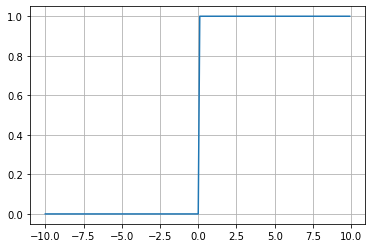

In [62]:
def step(a):
    return np.array(a > 0, dtype = np.int)

x = np.arange(-10.0, 10.0, 0.1)
y = step(x)

plt.plot(x, y)
plt.grid()
plt.show()

* 신경망에서는 이런 계단 함수를 출력 함수로 사용하지 않는다.
* 대신 로지스틱 함수를 사용해보자.


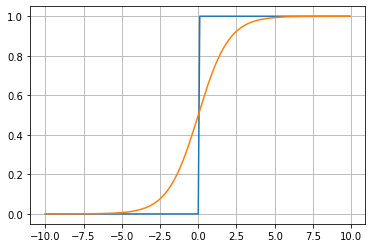

In [63]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

y1 = step(x)
y2 = sigmoid(x)

plt.plot(x, y1)
plt.plot(x, y2)
plt.grid()
plt.show()

* 로지스틱 회귀를 사용해도 카테고리가 0인지 1인지 분류할 수 있다.
* 기계학습에서는 가능한 한 현실과 가까운 분류기나 예측 모델을 만드는 것이다:
  * 따라서 계단 함수와 같이 0, 1만 출력하는 함수로는 손실을 계산해 최적의 파라미터를 찾는 학습을 할 수 없다.
* 최근에는 보다 단순한 형태를 보이는 ReLU(Rectified Linear Unit, 정류된 선형함수)가 출력 함수로 많이 사용된다:
  $y = \begin{cases} 0 &(w_1x_1 + w_2x_2 + b \leq 0) \\ 1 &(w_1x_1 + w_2x_2 + b \gt 0) \end{cases}$

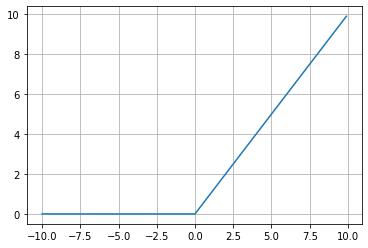

In [65]:
def relu(a):
    return np.maximum(0, a)

y3 = relu(x)

plt.plot(x, y3)
plt.grid()
plt.show()

* 로지스틱 함수 대신 ReLU 함수를 활성화 함수로 사용하는 이유:
  * 로지스틱 함수는 0에서 1 사이의 값만 출력한다.
  * 그런데 경사하강법으로 최적의 파라미터를 찾는 과정에서 은닉층이 많아져 미분 계산도 많아진다.
  * 그래서 기울기 값이 0에 가까워지는 경사 손실(vanishing gradient) 현상이 발생한다.
  * 따라서 최적의 파라미터를 찾지 못했음에도 기울기가 0에 가깝게 되어 학습이 종료된다.
* ReLU 함수는 0보다 큰 값의 경우 출력값과 같은 값을 가지므로, 로지스틱 함수보다 경사 손실이 덜 발생한다.

#### 퍼셉트론 간의 신호를 전달하는 순전파(Feed Forward)

* 2개의 노드로 이뤄진 입력층, 3개의 노드로 이뤄진 은닉층, 2개의 노드로 이뤄진 출력층:
  ![](https://user-images.githubusercontent.com/6410412/107135120-65fd0600-693b-11eb-86d9-1d676b538660.png)
* 문자 표기 정리:
  * $x_n$ - 입력층의 $n$번째 노드에 최초 입력되는 값 $x$
  * $y_n$ - 출력층의 $n$번째 노드에서 최종 출력되는 값 $y$
  * $a_n^k$ - $k$번째 계층의 $n$번째 노드에 입력된 신호의 합 $a$
  * $z_n^k$ - $k$번째 계층의 $n$번째 노드에서 출력되는 신호 $z$
* 각 과정에서 일어나는 계산을 자세히 보자:

##### 1단계 - 입력층 내에서의 신호 전달

* 특별한 계산 없이 입력값을 그대로 출력한다: $z_1^0 = a_1^0 = x_1, z_2^0 = a_2^0 = x_2$

##### 2단계 - 입력층에서 은닉층으로

* 입력층에서 출력한 신호 $z$는 은닉층에 입력되는 신호의 합 $a$로 전달된다.
* $w_{mn}$ - 이전 계층의 $m$번째 노드에서 다음 계층의 $n$번째 노드로 신호 전달 시 적용되는 가중치 $w$
* $b_n$ - 다음 계층의 $n$번째 노드로 신호 전달 시 적용되는 편향 $b$
* 그림과 식으로 나타내면 아래와 같다:
  ![](https://user-images.githubusercontent.com/6410412/107135731-7e235400-6940-11eb-9128-a724c7b04f10.png)
* 세 등식에서 반복되는 규칙성에 따라 행렬 표현을 이용하면 하나의 등식으로 나타낼 수 있다:
  ![](https://user-images.githubusercontent.com/6410412/107136003-e3784480-6942-11eb-9736-a5dce1d9ddc1.png)
  * 식을 다음과 같이 정리할 수 있다: $A^1 = Z^0W + B$
  * 자연수 $k$에 대하여 $k - 1$ 계층과 $k$ 계층의 노드 수가 각각 $m$ro, $n$개이면 $k - 1$ 계층에서 $k$ 계층으로 신호가 전달될 때 적용되는 가중치와 편향 데이터 셋 W, B의 꼴이 다음과 같다:
    * $W$ - $m$행 $n$열 꼴의 데이터 셋, e.g., $W = \begin{pmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23} \end{pmatrix}$
    * $B$ - 1행 $n$열 꼴의 데이터 셋, e.g., $B = (b_1, b_2, b_3)$

##### 3단계 - 은닉층 내에서의 신호 전달

* 은닉층의 노드에서는 전달받은 신호들의 합 $a$를 활성화 함수 $g$에 대응시킨 값 $z$를 출력한다:
* 즉, $z_1^1 = g(a_1^1), z_2^1 = g(a_2^1), z_3^1 = g(a_3^1)$
* 행렬 표현으로 나타내면: 입력 $A^1 = (a_1^1, a_2^1, a_3^1)$, 출력 $Z^1 = (z_1^1, z_2^1, z_3^1)$에 대하여, $g(X^1) = A^1$

##### 4단계 - 은닉층에서 출력층으로

![](https://user-images.githubusercontent.com/6410412/107137207-803fdf80-694d-11eb-8796-bb8bcc757d89.png)

* 3개의 노드를 가진 계층에서 2개의 노드를 갖는 계층으로 신호가 전달된다.
  * 따라서 $3 \times 2$꼴의 가중치 행렬 $W\prime$과 $1 \times 2$꼴의 편향 행렬 $B\prime$을 각각 곱하고 더한다.
    ![](https://user-images.githubusercontent.com/6410412/107137392-630c1080-694f-11eb-922e-e6d5ab6b05c7.png)
* $W\prime = \begin{pmatrix} w\prime_{11} & w\prime_{12} \\ w\prime_{21} & w\prime_{22} \\ w\prime_{31} & w\prime_{32} \end{pmatrix}$
* $B\prime = (b\prime_1, b\prime_2)$
* 다음의 관계가 성립한다: $A^2 = Z^1W\prime + B\prime$

##### 5단계 - 출력층 내에서의 신호 전달

* 전달받은 신호들의 합을 활성화 함수 $g$에 대응시킨 값을 출력한다.
* 최종 출력 값이므로 $z$가 아닌 $y$로 표현하면: $y_1 = z_1^2 = g(a_1^2), y_2 = z_2^2 = g(a_2^2)$
* 최종 출력값이 예측을 위한 선형회귀 모델이라면 특정 수이어야 하므로, 활성화 함수 $g$로 항등 함수를 적용한다.
* 분류를 위한 신경망이라면 출력층의 10개 노드는 각각 10가지 종류의 카테고리에 대응된다:
  * 이때는 각각의 노드가 출력한 값을 통해 입력 값이 어떤 종류인지 판정하기 위해 출력값이 확률적인 의미를 가져야 한다.
  * 이대 사용하는 대표적인 활성화 함수가 소프트맥스 함수(softmax function)이다.

In [70]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

1.0


* 소프트맥스 함수에 의해 최종 출력된 값은 확률의 의미를 가진다.
* 따라서 신경망은 출력층의 각 노드가 최종 출력한 값(확률) 중에서 가장 높은 것을 택한다.

In [73]:
X = np.array([0.1, 0.2])
W1 = np.array([[1, 2, 3], [4, 5, 6]])
B1 = np.array([1, 2, 3])

A1 = np.dot(X, W1) + B1
Z1 = sigmoid(A1)

print(A1)
print(Z1)
print(X.shape, W1.shape, B1.shape, A1.shape)

W2 = np.array([[1, 2], [3, 4], [5, 6]])
B2 = np.array([-1, 1])
A2 = np.dot(Z1, W2) + B2
Y = softmax(A2)

print(A2)
print(Y)

print(Z1.shape, W2.shape, B2.shape, A2.shape)

[1.9 3.2 4.5]
[0.86989153 0.96083428 0.98901306]
(2,) (2, 3) (3,) (3,)
[ 7.69745964 12.5171985 ]
[0.00800431 0.99199569]
(3,) (3, 2) (2,) (2,)


* Fashion MNIST 데이터 셋으로 옷의 종류를 구별하는 분류 모델의 작동 과정을 예상해본다:
  * 의류 이미지는 784개 픽셀을 가지므로, 입력층의 노드는 784개댜.
  * 의류 종류는 10개이므로, 출력층의 노드는 10개다.
  * 정확한 예측을 위해 은닉층에는 100개의 노드를 사용한다.
* 간단한 신경망 클래스를 만들어 보자.


In [74]:
class NN01:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        self.w1 = np.random.rand(self.input_nodes, self.hidden_nodes) / np.sqrt(self.input_nodes / 2)
        self.b1 = np.random.rand(self.hidden_nodes)

        self.w2 = np.random.rand(self.hidden_nodes, self.output_nodes) / np.sqrt(self.hidden_nodes / 2)
        self.b2 = np.random.rand(self.output_nodes)

        self.learning_rate = learning_rate

    def feed_forward(self):
        delta = 1e-7
        a1 = np.dot(self.input_data, self.w1) + self.b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, self.w2) + self.b2
        y = sigmoid(a2)
        return -np.sum(self.target_data * np.log(y + delta) + (1 - self.target_data) * np.log((1 - y) + delta))

#### 파라미터를 결정하는 비용함수

* 신경망 모델에서 나온 $Y$ 값과 실제 $Y$ 값의 차이를 최소로하는 가중치를 찾는다.
* 비용함수로 로그최대우도추정법을 사용한다:
  * 기존에는 파라미터로 $\beta_0, \beta_1$을 사용했지만, 이제는 가중치 $W$와 편향 $B$를 사용한다.